<a href="https://colab.research.google.com/github/SM12345678/DeepLearningFinalProject/blob/main/Final_Copy_with_bottle_DL_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
! ls

gdrive	sample_data


In [ ]:
pwd  HierarchicalObjectDetectionWithDeepRL

'/content'

In [ ]:
%cd /content/gdrive/MyDrive/DLProject/ HierarchicalObjectDetectionWithDeepRL

/content/gdrive/MyDrive/DLProject/ HierarchicalObjectDetectionWithDeepRL


In [ ]:
!git clone https://github.com/SM12345678/Pytorch_Deep_RL_1.git

fatal: destination path 'Pytorch_Deep_RL_1' already exists and is not an empty directory.


In [ ]:
pwd

'/content/gdrive/My Drive/DLProject/ HierarchicalObjectDetectionWithDeepRL'

In [ ]:
! git pull

fatal: not a git repository (or any parent up to mount point /content)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).


In [ ]:
pwd

'/content/gdrive/MyDrive/DLProject/ HierarchicalObjectDetectionWithDeepRL'

In [ ]:
%cd /content/gdrive/MyDrive/DLProject/ HierarchicalObjectDetectionWithDeepRL/Pytorch_Deep_RL_1

/content/gdrive/MyDrive/DLProject/ HierarchicalObjectDetectionWithDeepRL/Pytorch_Deep_RL_1


In [ ]:
# For GPU:
!pip3 install 'tensorflow-gpu>=2.2.0'

     |████████████████████████████████| 454.3MB 35kB/s 
     |████████████████████████████████| 4.0MB 30.5MB/s 
     |████████████████████████████████| 1.2MB 20.2MB/s 
     |████████████████████████████████| 471kB 37.2MB/s 
     |████████████████████████████████| 6.0MB 27.9MB/s 
     |████████████████████████████████| 4.0MB 27.4MB/s 
     |████████████████████████████████| 4.9MB 17.5MB/s 
ERROR: tensorflow 2.4.1 has requirement gast==0.3.3, but you'll have gast 0.4.0 which is incompatible.
ERROR: tensorflow 2.4.1 has requirement grpcio~=1.32.0, but you'll have grpcio 1.34.1 which is incompatible.
ERROR: tensorflow 2.4.1 has requirement h5py~=2.10.0, but you'll have h5py 3.1.0 which is incompatible.
ERROR: tensorflow 2.4.1 has requirement tensorflow-estimator<2.5.0,>=2.4.0, but you'll have tensorflow-estimator 2.5.0 which is incompatible.
  Found existing installation: grpcio 1.32.0
    Uninstalling grpcio-1.32.0:
      Successfully uninstalled grpcio-1.32.0
  Found existing installatio

In [ ]:
import torch
torch.cuda.is_available()

True

In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
import torch
import random
import torchvision
import torch.nn.init as init
import torch.nn as nn
from collections import namedtuple
from features import *
from random import random
import random as rand

# Different actions that the agent can do
number_of_actions = 6
# Actions captures in the history vector
actions_of_history = 4
# Visual descriptor size
visual_descriptor_size = 25088
# Reward movement action
reward_movement_action = 1
# Reward terminal action
reward_terminal_action = 3
# IoU required to consider a positive detection
iou_threshold = 0.5


Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))
class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return rand.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

    
def get_state(image, history_vector, model_vgg, dtype=torch.cuda.FloatTensor):
    image_feature = get_conv_feature_for_image(image, model_vgg,dtype)
    image_feature = image_feature.view(1,-1)
    history_vector_flatten = history_vector.view(1,-1).type(dtype)
    state = torch.cat((image_feature, history_vector_flatten), 1)
    return state


# FIFO
def update_history_vector(history_vector, action):
    action_vector = torch.zeros(number_of_actions)
    action_vector[action-1] = 1
    size_history_vector = len(torch.nonzero(history_vector))    
    if size_history_vector < actions_of_history:
        history_vector[size_history_vector][action-1] = 1
    else:
        for i in range(actions_of_history-1,0,-1):
            history_vector[i][:] = history_vector[i-1][:]
        history_vector[0][:] = action_vector[:] 
    return history_vector


def get_q_network(weights_path="0"):
    model = nn.Sequential(
                nn.Linear(25112, 1024),
                nn.ReLU(),
                nn.Dropout(0.2),
                nn.Linear(1024, 1024),
                nn.ReLU(),
                nn.Dropout(0.2),
                nn.Linear(1024, 6),
    )
    if weights_path != "0":
        model.load_state_dict(torch.load(weights_path))
    # init weights by xavier_normal, it may be different with the author's implements
    def weights_init(m):
        if isinstance(m, nn.Linear):
            init.xavier_normal(m.weight.data)
    model.apply(weights_init)
    return model


def get_reward_movement(iou, new_iou):
    if new_iou > iou:
        reward = reward_movement_action
    else:
        reward = - reward_movement_action
    return reward


def get_reward_trigger(new_iou):
    if new_iou > iou_threshold:
        reward = reward_terminal_action
    else:
        reward = - reward_terminal_action
    return reward

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:285: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


In [ ]:
import torch
import torchvision
import torch.optim as optim
from torch.autograd import Variable
from image_helper import *
from parse_xml_annotations import *
from features import *
#from reinforcement import *
from metrics import *
from collections import namedtuple
import time
import os
import numpy as np
import random as rand
from random import random


os.environ["CUDA_VISIBLE_DEVICES"] = "1"
path_voc = "datas/VOCdevkit/VOC2007"

# get models 
print("load models")

model_vgg = getVGG_16bn("models")
model_vgg = model_vgg.cuda()
model = get_q_network()
model = model.cuda()

# define optimizers for each model
optimizer = optim.Adam(model.parameters(),lr=1e-6)
criterion = nn.MSELoss().cuda()   

# get image datas
path_voc_1 = "datas/VOCdevkit/VOC2007"
#path_voc_2 = "datas/VOCdevkit/VOC2012"
class_object = '1'
image_names_1, images_1 = load_image_data(path_voc_1, class_object)
#image_names_2, images_2 = load_image_data(path_voc_2, class_object)
image_names = image_names_1 
images = images_1

print("bottle_trainval image:%d" % len(image_names))

# define the Pytorch Tensor
use_cuda = torch.cuda.is_available()
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if use_cuda else torch.ByteTensor
Tensor = FloatTensor

# define the super parameter
epsilon = 1.0
BATCH_SIZE = 100
GAMMA = 0.90
CLASS_OBJECT = 1
steps = 10
epochs = 50
memory = ReplayMemory(1000)

def select_action(state):
    if rand.random() < epsilon:
        action = np.random.randint(1,7)
    else:
        qval = model(Variable(state))
        _, predicted = torch.max(qval.data,1)
        action = predicted[0] + 1
    return action


Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))
def optimizer_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))
    
    non_final_mask = ByteTensor(tuple(map(lambda s: s is not None, batch.next_state)))
    next_states = [s for s in batch.next_state if s is not None]
    non_final_next_states = Variable(torch.cat(next_states), 
                                     volatile=True).type(Tensor)
    state_batch = Variable(torch.cat(batch.state)).type(Tensor)
    action_batch = Variable(torch.LongTensor(batch.action).view(-1,1)).type(LongTensor)
    reward_batch = Variable(torch.FloatTensor(batch.reward).view(-1,1)).type(Tensor)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken
    state_action_values = model(state_batch).gather(1, action_batch)
    
    # Compute V(s_{t+1}) for all next states.
    next_state_values = Variable(torch.zeros(BATCH_SIZE, 1).type(Tensor)) 

    x = torch.tensor(model(non_final_next_states).max(1)[0])
    next_state_values[non_final_mask] = x.unsqueeze(1)
    #next_state_values[non_final_mask] = model(non_final_next_states).max(1)[0]
    
    # Now, we don't want to mess up the loss with a volatile flag, so let's
    # clear it. After this, we'll just end up with a Variable that has
    # requires_grad=False
    next_state_values.volatile = False
    
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch
    
    # Compute  loss
    loss = criterion(state_action_values, expected_state_action_values)

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# train procedure
print('train the Q-network')
for epoch in range(epochs):
    print('epoch: %d' %epoch)
    now = time.time()
    for i in range(len(image_names)):
        # the image part
        image_name = image_names[i]
        image = images[i]
        if i < len(image_names_1):
            annotation = get_bb_of_gt_from_pascal_xml_annotation(image_name, path_voc_1)
        else:
            annotation = get_bb_of_gt_from_pascal_xml_annotation(image_name, path_voc_2)            
        classes_gt_objects = get_ids_objects_from_annotation(annotation)
        gt_masks = generate_bounding_box_from_annotation(annotation, image.shape) 
         
        # the iou part
        original_shape = (image.shape[0], image.shape[1])
        region_mask = np.ones((image.shape[0], image.shape[1]))
        #choose the max bouding box
        iou = find_max_bounding_box(gt_masks, region_mask, classes_gt_objects, CLASS_OBJECT)
        
        # the initial part
        region_image = image
        size_mask = original_shape
        offset = (0, 0)
        history_vector = torch.zeros((4,6))
        state = get_state(region_image, history_vector, model_vgg)
        done = False
        for step in range(steps):
            # Select action, the author force terminal action if case actual IoU is higher than 0.5
            if iou > 0.5:
                action = 6
            else:
                action = select_action(state)
            
            # Perform the action and observe new state
            if action == 6:
                next_state = None
                reward = get_reward_trigger(iou)
                done = True
            else:
                offset, region_image, size_mask, region_mask = get_crop_image_and_mask(original_shape, offset,
                                                                   region_image, size_mask, action)
                # update history vector and get next state
                history_vector = update_history_vector(history_vector, action)
                next_state = get_state(region_image, history_vector, model_vgg)
                
                # find the max bounding box in the region image
                new_iou = find_max_bounding_box(gt_masks, region_mask, classes_gt_objects, CLASS_OBJECT)
                reward = get_reward_movement(iou, new_iou)
                iou = new_iou
            print('epoch: %d, image: %d, step: %d, reward: %d' %(epoch ,i, step, reward))    
            # Store the transition in memory
            memory.push(state, action-1, next_state, reward)
            
            # Move to the next state
            state = next_state
            
            # Perform one step of the optimization (on the target network)
            optimizer_model()
            if done:
                break
    if epsilon > 0.1:
        epsilon -= 0.1
    time_cost = time.time() - now
    print('epoch = %d, time_cost = %.4f' %(epoch, time_cost))
    
# save the whole model
Q_NETWORK_PATH = '../models/' + 'voc2012_2007_model'
torch.save(model, Q_NETWORK_PATH)
print('Complete')

load models


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:84: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.


load imagesdatas/VOCdevkit/VOC2007
total image:244
bottle_trainval image:244
train the Q-network
epoch: 0
epoch: 0, image: 0, step: 0, reward: -1
epoch: 0, image: 0, step: 1, reward: -1
epoch: 0, image: 0, step: 2, reward: -1
epoch: 0, image: 0, step: 3, reward: -1
epoch: 0, image: 0, step: 4, reward: -1
epoch: 0, image: 0, step: 5, reward: -1
epoch: 0, image: 0, step: 6, reward: -1
epoch: 0, image: 0, step: 7, reward: -1
epoch: 0, image: 0, step: 8, reward: -1
epoch: 0, image: 0, step: 9, reward: -1
epoch: 0, image: 1, step: 0, reward: -3
epoch: 0, image: 2, step: 0, reward: -3
epoch: 0, image: 3, step: 0, reward: -3
epoch: 0, image: 4, step: 0, reward: -1
epoch: 0, image: 4, step: 1, reward: -1
epoch: 0, image: 4, step: 2, reward: -1
epoch: 0, image: 4, step: 3, reward: -3
epoch: 0, image: 5, step: 0, reward: -1
epoch: 0, image: 5, step: 1, reward: -1
epoch: 0, image: 5, step: 2, reward: -1
epoch: 0, image: 5, step: 3, reward: -1
epoch: 0, image: 5, step: 4, reward: -1
epoch: 0, imag

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:79: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:91: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:92: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Streaming output truncated to the last 5000 lines.
epoch = 31, time_cost = 7.7666
epoch: 32
epoch: 32, image: 0, step: 0, reward: -3
epoch: 32, image: 1, step: 0, reward: -3
epoch: 32, image: 2, step: 0, reward: -3
epoch: 32, image: 3, step: 0, reward: -3
epoch: 32, image: 4, step: 0, reward: -3
epoch: 32, image: 5, step: 0, reward: -1
epoch: 32, image: 5, step: 1, reward: -3
epoch: 32, image: 6, step: 0, reward: -1
epoch: 32, image: 6, step: 1, reward: -1
epoch: 32, image: 6, step: 2, reward: -1
epoch: 32, image: 6, step: 3, reward: -3
epoch: 32, image: 7, step: 0, reward: -1
epoch: 32, image: 7, step: 1, reward: -3
epoch: 32, image: 8, step: 0, reward: -1
epoch: 32, image: 8, step: 1, reward: -3
epoch: 32, image: 9, step: 0, reward: -1
epoch: 32, image: 9, step: 1, reward: -3
epoch: 32, image: 10, step: 0, reward: -3
epoch: 32, image: 11, step: 0, reward: -3
epoch: 32, image: 12, step: 0, reward: -3
epoch: 32, image: 13, step: 0, reward: -3
epoch: 32, image: 14, step: 0, reward: -3
e

In [ ]:
import os
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.utils.data as data
import torch.optim as optim
from torch.autograd import Variable
import random
import matplotlib.pyplot as plt
%matplotlib inline
from image_helper import *
from parse_xml_annotations import *
from features import *
from reinforcement import *
from metrics import *
import logging
import time
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [ ]:
print("load images")
path_voc = "datas/VOCdevkit/VOC2007/JPEGTestImages"
image_names = np.array(load_images_names_in_data_set('bottle_test', path_voc))
labels = load_images_labels_in_data_set('bottle_test', path_voc)
image_names_aero = []
for i in range(len(image_names)):
    if labels[i] == '1':
        image_names_aero.append(image_names[i])
image_names = image_names_aero
images = get_all_images(image_names, path_voc)
print("bottle_test image:%d" % len(image_names))




load images
bottle_test image:212


In [ ]:
Q_NETWORK_PATH ='../models/voc2012_2007_model'
model = torch.load(Q_NETWORK_PATH)
model_vgg = getVGG_16bn("models")
model_vgg = model_vgg.cuda()

In [ ]:
def draw_bouding_box_1(annotation, img):
    new_img = Image.fromarray(img)
    draw = ImageDraw.Draw(new_img)
    length = len(annotation)
    annotation = np.array(annotation)
    for i in range(length):
        x_min = int(annotation[i,1])
        x_max = int(annotation[i,2])
        y_min = int(annotation[i,3])
        y_max = int(annotation[i,4])
        draw.line(((x_min, y_min), (x_max, y_min)), fill="red", width=3)
        draw.line(((x_min, y_min), (x_min, y_max)), fill="red", width=3)
        draw.line(((x_max, y_min), (x_max, y_max)), fill="red", width=3)
        draw.line(((x_min, y_max), (x_max, y_max)), fill="red", width=3)
    plt.figure()
    plt.imshow(new_img)

def get_annotation(offset, size_mask):
    annotation = np.zeros(5)
    annotation[3] = offset[0]
    annotation[4] = offset[0] + size_mask[0]
    annotation[1] = offset[1]
    annotation[2] = offset[1] + size_mask[1] 
    return annotation

In [ ]:
class_object = 1
steps = 10
res = []
res_step = []
res_annotations = []
for i in range(len(image_names)):
    image_name = image_names[i]
    image = images[i]
    
    # get use for iou calculation
    gt_annotation = get_bb_of_gt_from_pascal_xml_annotation(image_name, path_voc)
    original_shape = (image.shape[0], image.shape[1])
    classes_gt_objects = get_ids_objects_from_annotation(gt_annotation)
    gt_masks = generate_bounding_box_from_annotation(gt_annotation, image.shape)
    
    # the initial part
    region_image = image
    size_mask = image.shape
    region_mask = np.ones((image.shape[0], image.shape[1]))
    offset = (0, 0)
    history_vector = torch.zeros((4,6))
    state = get_state(region_image, history_vector, model_vgg)
    done = False
    
    # save the bounding box maked by agent
    annotations = []
    annotation = get_annotation(offset, size_mask)
    annotations.append(annotation)
    
    for step in range(steps):
            # Select action
            qval = model(Variable(state))
            _, predicted = torch.max(qval.data,1)
            action = predicted[0] + 1
            # Perform the action and observe new state
            if action == 6:
                next_state = None
                done = True
            else:
                offset, region_image, size_mask, region_mask = get_crop_image_and_mask(original_shape, offset,
                                                                   region_image, size_mask, action)
               
                #print(offset, size_mask, region_image.shape, region_mask.shape)
                annotation = get_annotation(offset, size_mask)
                annotations.append(annotation)
                history_vector = update_history_vector(history_vector, action)
                next_state = get_state(region_image, history_vector, model_vgg)

            # Move to the next state
            state = next_state
            if done:
                print('done!!')
                res_step.append(step)
                res_annotations.append((gt_annotation, annotations, image))
                break
                
    iou = find_max_bounding_box(gt_masks, region_mask, classes_gt_objects, class_object)
    print(iou)
    pos = 0
    reward = qval.data[0,5]
    if iou > 0.5:
        pos = 1
    print(reward)
    print(pos)
    res.append((reward, pos))

done!!
0.0
tensor(-3.1159, device='cuda:0')
0
done!!
0.0
tensor(-3.2755, device='cuda:0')
0
done!!
0.0
tensor(-3.2548, device='cuda:0')
0
done!!
0.0
tensor(-3.0469, device='cuda:0')
0
done!!
0.0
tensor(-2.9107, device='cuda:0')
0
done!!
0.0
tensor(-3.0864, device='cuda:0')
0
done!!
0.0
tensor(-3.2250, device='cuda:0')
0
done!!
0.0
tensor(-3.2298, device='cuda:0')
0
done!!
0.0
tensor(-3.2066, device='cuda:0')
0
done!!
0.0
tensor(-2.9724, device='cuda:0')
0
done!!
0.0
tensor(-2.4775, device='cuda:0')
0
done!!
0.0
tensor(-3.4013, device='cuda:0')
0
done!!
0.0
tensor(-2.8321, device='cuda:0')
0
done!!
0.0
tensor(-3.0462, device='cuda:0')
0
done!!
0.0
tensor(-2.9789, device='cuda:0')
0
done!!
0.0
tensor(-2.6488, device='cuda:0')
0
done!!
0.0
tensor(-3.1335, device='cuda:0')
0
done!!
0.0
tensor(-2.7657, device='cuda:0')
0
done!!
0.0
tensor(-3.2497, device='cuda:0')
0
done!!
0.0
tensor(-3.6012, device='cuda:0')
0
done!!
0.0
tensor(-2.3151, device='cuda:0')
0
done!!
0.0
tensor(-3.1305, device=

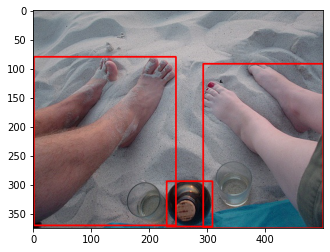

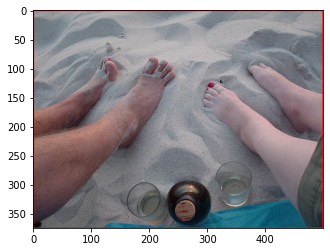

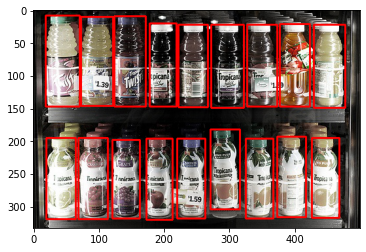

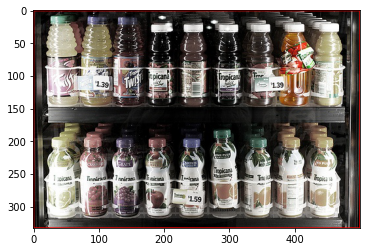

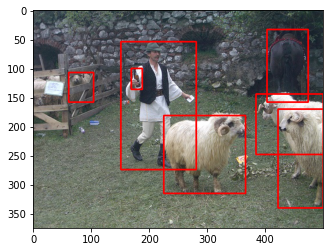

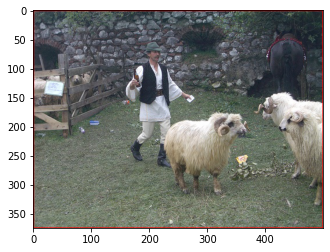

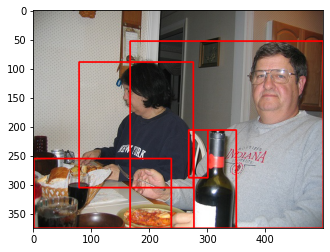

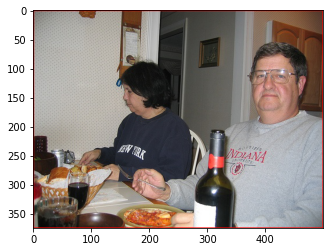

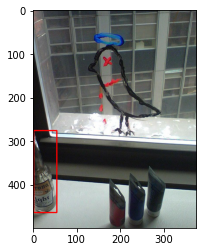

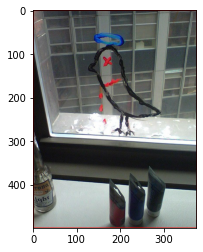

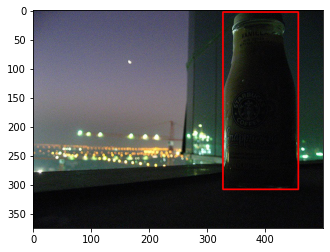

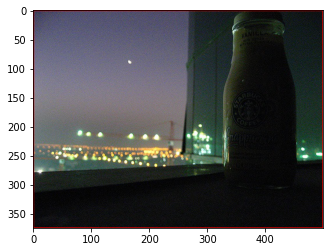

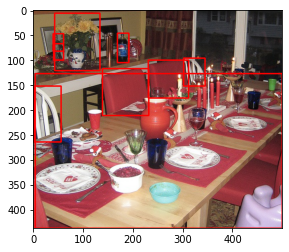

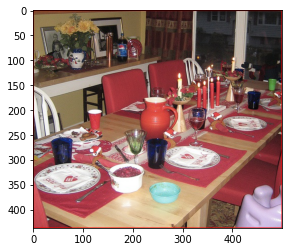

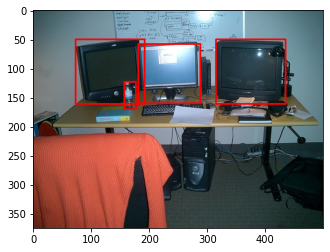

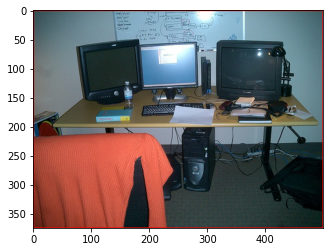

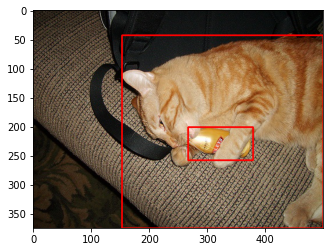

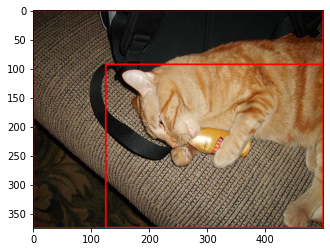

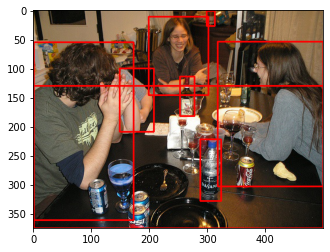

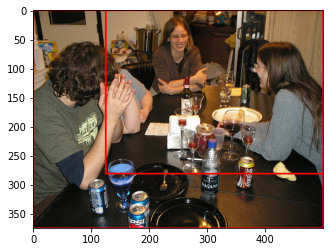

In [ ]:
begin = 170
end = begin + 10
for i in range(begin, end):
    gt_annotation, annotation, image = res_annotations[i]
    draw_bouding_box_1(gt_annotation, image)
    draw_bouding_box_1(annotation, image)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[tensor(-2.8226, device='cuda:0'), tensor(-3.1544, device='cuda:0'), tensor(-3.1645, device='cuda:0'), tensor(-3.0503, device='cuda:0'), tensor(-3.1696, device='cuda:0'), tensor(-3.2312, device='cuda:0'), tensor(-3.5366, device='cuda:0'), tensor(-3.4273, device='cuda:0'), tensor(-3.2206, device='cuda:0'), tensor(-3.0102, device='cuda:0'), tensor(-2.8018, device

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:677: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


Text(0.5, 1.0, '2-class Precision-Recall curve: AP=nan')

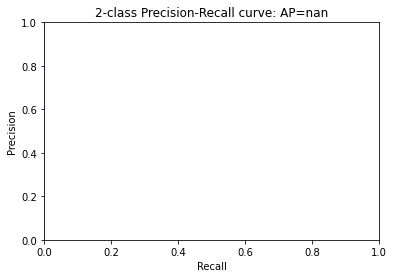

In [ ]:
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
y_test = [x[1] for x in res]
y_score = [x[0] for x in res]
y_test = y_test[::-1]
y_score = y_score[::-1]
print(y_test)
print(y_score)
average_precision = average_precision_score(y_test, y_score)
print(average_precision)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))
precision, recall, _ = precision_recall_curve(y_test, y_score)
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1])
plt.xlim([0.0, 1])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))

Text(0.5, 0, 'Number of regions')

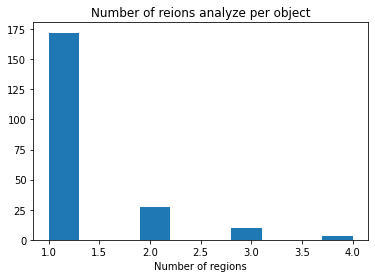

In [ ]:
res_step = np.array(res_step) + 1
plt.hist(res_step)
plt.title('Number of reions analyze per object')
plt.xlabel('Number of regions')
